<a href="https://colab.research.google.com/github/shrutikakubal/KG/blob/main/simple_kg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import spacy #NLP library - Sentence Detection, Frequent Word Removal, Type-of-word detection (noun, action etc), lemmatization (reduce to root), similarity
import numpy as np
import pandas as pd #CSV file I/O (e.g. pd.read_csv)
import os
file_name = "wiki_sentences_v2.csv"
with open(file_name, 'r') as file:
    content = file.read()
#Load nlp model - sm=trained with less data
nlp = spacy.load('en_core_web_sm')
#create nlp object - tokenize the text
doc = nlp("The meeting is on friday")
#create dependency relation (syntactic) between word and parent
for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
meeting ... nsubj
is ... ROOT
on ... prep
friday ... pobj


# New Section

In [3]:
#Named Entity Recognition
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

friday 18 24 DATE


In [5]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
#nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [6]:
sentences=pd.read_csv(file_name)
print(sentences)

                                                                                                      sentence
0                                                 confused and frustrated, connie decides to leave on her own.
1                                                            later, a woman’s scream is heard in the distance.
2                                                                     christian is then paralyzed by an elder.
3                                                                                   the temple is set on fire.
4                                                                            outside, the cult wails with him.
...                                                                                                        ...
4313     confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent.
4314                                             and le parisien gave the film their highest five-star rating.
4

In [7]:
#entity pair extraction
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier (adjective, quantifier, "very" before "very quickly") or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it (e.g. "goodbye, highrise")
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3 - find subject (entity one)
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4 - find object (entity two)
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [8]:
get_entities("I have so much work")

['I', 'much  work']

In [9]:
entity_pairs = []

#tqdm -> show progress bar
for i in tqdm(sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:40<00:00, 106.44it/s]


In [10]:
def  get_relation(sent):

    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    #find root, prepositional modifier, agent (do-er), adjective
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1",[pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    #last matching substring
    span = doc[matches[k][1]:matches[k][2]]

    return(span.text)

In [11]:
get_relation("Shruti went for a run")

'went for'

In [12]:

relations = [get_relation(i) for i in tqdm(sentences['sentence'])]

100%|██████████| 4318/4318 [00:38<00:00, 112.43it/s]


In [13]:
#Series (key-value pairs) containing the counts of the 50 most frequent relations
#pd.Series(relations).value_counts()[:50]

#entity_pairs[0:10]
#relations[0:10]
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df[0:10]

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
5,it,religious awakening,'s
6,c. mackenzie,craig cast,joined
7,later craig di francia,action cast,revealed
8,sebastian maniscalco,later paul ben cast,revealed as
9,we,just film,tried


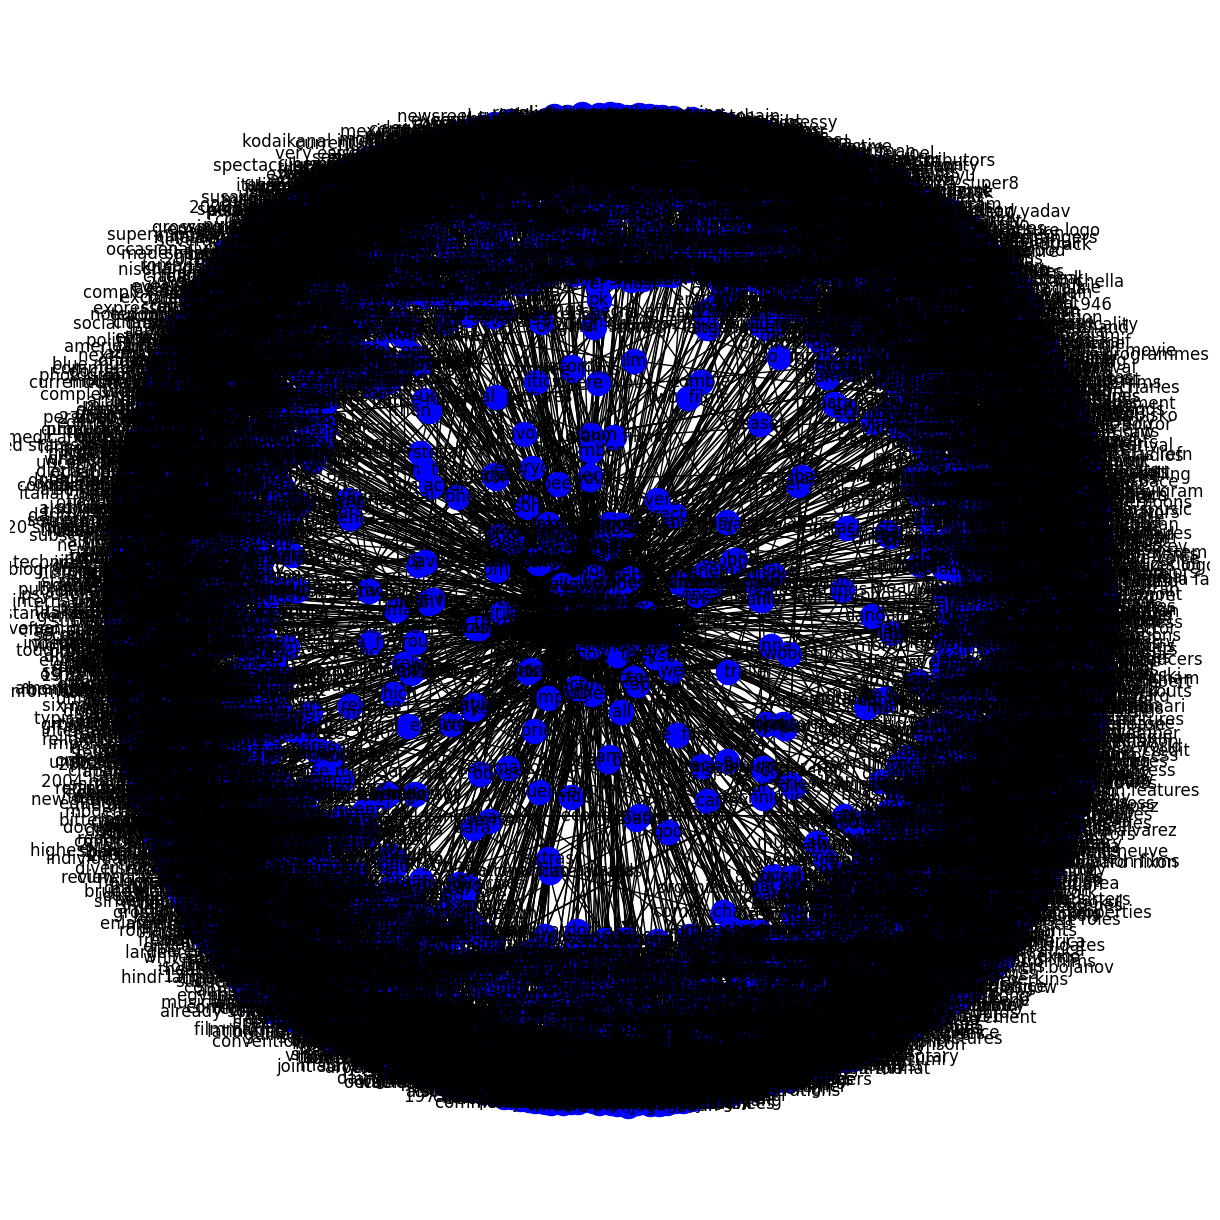

In [14]:
#create graph
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='blue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


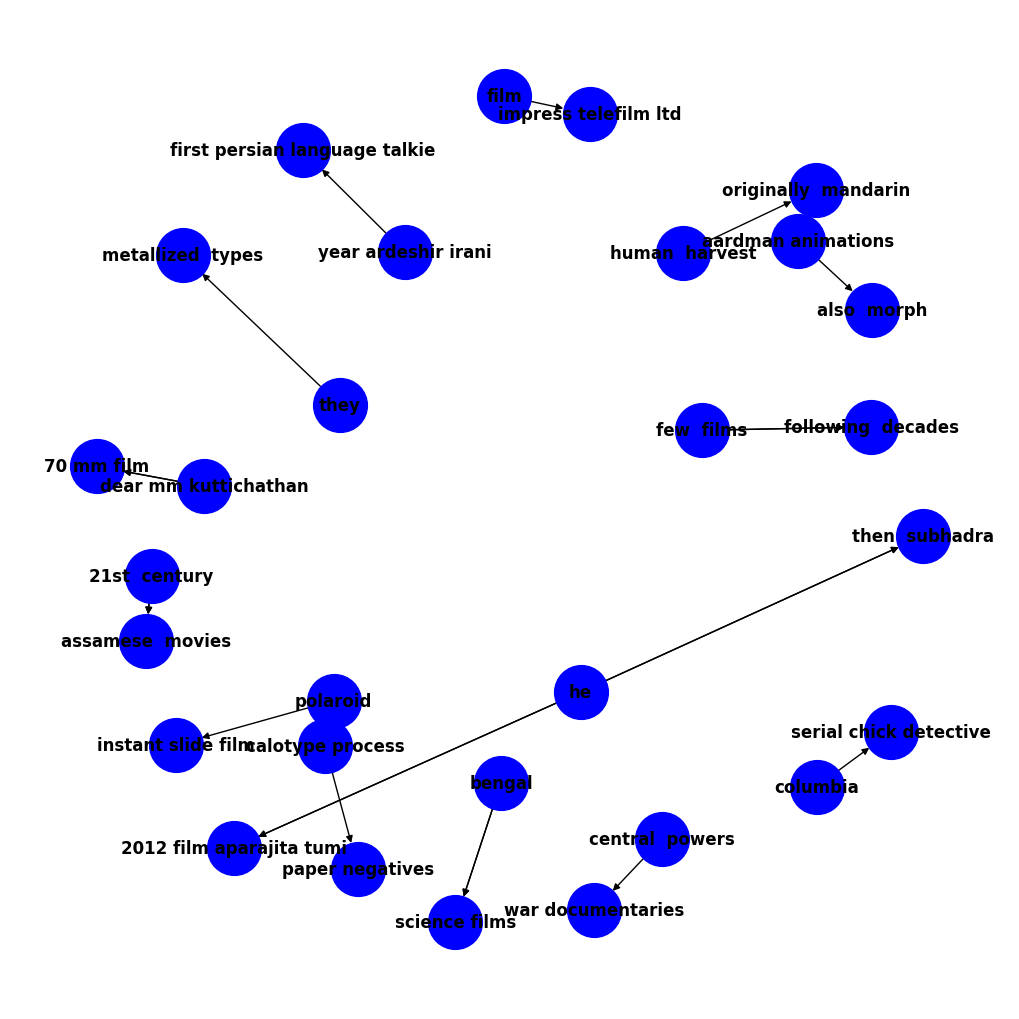

In [15]:
#Filter on some relation
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="produced"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k = 0.5) # bigger k = more distance between nodes
nx.draw(G, with_labels=True, node_color='blue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()